<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/BP_PPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, h5py, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -----------------------------
# 0) 환경/시드 고정
# -----------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# 1) 경로 설정
# -----------------------------
mat_path = "/content/drive/MyDrive/Colab Notebooks/p096530.mat"


In [ ]:
# 2) MATLAB v7.3(HDF5) 로더
# -----------------------------
def load_mat_v73(filepath):
    """
    MATLAB v7.3 HDF5 구조에서
    PPG_Raw, ECG_Raw, SegSBP, SegDBP, SubjectID 추출
    """
    f = h5py.File(filepath, "r")
    refs = f["#refs#"]
    g = f["Subj_Wins"]

    def get_all(name):
        # Subj_Wins[name]는 object reference 테이블 -> #refs#의 실제 데이터로 역참조
        out = []
        table = g[name]
        n = table.shape[1]
        for i in range(n):
            ref = table[0, i]
            ds = refs[ref][()]
            out.append(ds)
        return out

    # 시계열 (윈도우 x 길이)
    ppg = np.vstack(get_all("PPG_Raw"))          # (N, L)
    # ECG는 이 PPG-only 코드에서는 사용하지 않지만,
    # 동일 함수로 ECG도 읽을 수 있게 만들어 둠
    ecg = np.vstack(get_all("ECG_Raw"))          # (N, L)

    sbp = np.array([float(x.squeeze()) for x in get_all("SegSBP")])  # (N,)
    dbp = np.array([float(x.squeeze()) for x in get_all("SegDBP")])  # (N,)

    # 환자번호: ASCII 코드 배열 → 문자열 (예: 'p096530')
    subj_ascii = get_all("SubjectID")[0].squeeze()
    subject_id = "".join(chr(int(c)) for c in subj_ascii)

    f.close()
    return ppg, ecg, sbp, dbp, subject_id

ppg, ecg, sbp, dbp, subject_id = load_mat_v73(mat_path)

print(f"[INFO] Patient(SubjectID): {subject_id}")
print(f"[INFO] PPG shape = {ppg.shape}, SBP shape = {sbp.shape}, DBP shape = {dbp.shape}")


[INFO] Patient(SubjectID): p096530
[INFO] PPG shape = (2200, 1250), SBP shape = (2200,), DBP shape = (2200,)


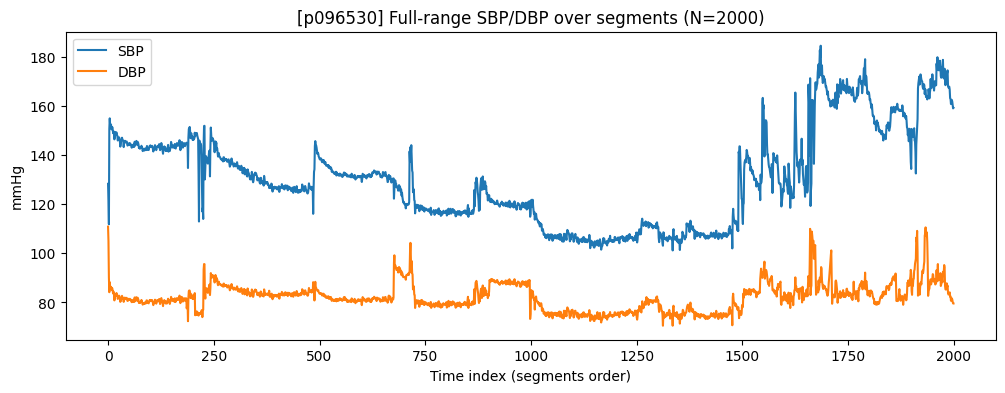

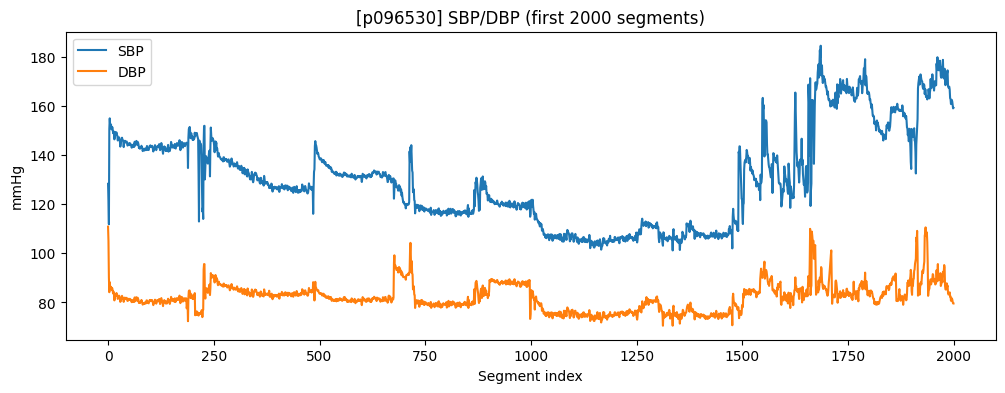

In [ ]:
# 3) 2000세그먼트만 사용 + 5-Fold 시간분할
# -----------------------------
MAX_SEG = 2000
N = min(len(sbp), MAX_SEG)

ppg = ppg[:N]
sbp = sbp[:N]
dbp = dbp[:N]

# 전구간(데이터 전체) SBP, DBP 시계열 그래프
plt.figure(figsize=(12,4))
plt.plot(sbp, label="SBP")
plt.plot(dbp, label="DBP")
plt.title(f"[{subject_id}] Full-range SBP/DBP over segments (N={N})")
plt.xlabel("Time index (segments order)")
plt.ylabel("mmHg")
plt.legend()
plt.show()

# 2000세그먼트 가시화: x=세그먼트 인덱스, y=혈압
x_idx = np.arange(N)
plt.figure(figsize=(12,4))
plt.plot(x_idx, sbp, label="SBP")
plt.plot(x_idx, dbp, label="DBP")
plt.title(f"[{subject_id}] SBP/DBP (first {N} segments)")
plt.xlabel("Segment index")
plt.ylabel("mmHg")
plt.legend()
plt.show()

# 5등분(시간순, 오버랩X) → fold별로 400개씩
FOLDS = 5
SEG_PER_FOLD = N // FOLDS  # 보통 2000//5=400
assert SEG_PER_FOLD >= 400, "각 fold에 최소 400세그먼트가 필요합니다."

# fold 내부 분할 규칙
TRN, VAL, TST = 320, 40, 40
assert TRN + VAL + TST == SEG_PER_FOLD

In [ ]:
# 4) 데이터 전처리
# -----------------------------
# Keras 1D Conv/LSTM 입력 형태: (samples, timesteps, channels)
# 채널=1(단일 PPG), timesteps=시계열 길이
X_all = ppg[..., None]  # (N, L, 1)
y_all = np.stack([sbp, dbp], axis=1)  # (N, 2)

input_length = X_all.shape[1]

In [ ]:
# 5) 모델 빌더 ( 1D CNN + BiLSTM)
# -----------------------------
def build_model_ppg(input_len):
    inp = layers.Input(shape=(input_len, 1))
    # 1D CNN으로 로우패스/특징추출
    x = layers.Conv1D(32, 7, padding="same", activation="relu")(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    # 시간패턴 캡처
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(2, activation="linear")(x)  # [SBP, DBP]
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="mae",   # 다중 타깃 MAE
        metrics=[keras.metrics.MAE]
    )
    return model

In [ ]:
# 6) Fold 학습/평가 루프
# -----------------------------
fold_mae = []   # fold별 (전체 타깃 평균 MAE)
fold_rmse = []  # fold별 (전체 타깃 평균 RMSE)

# 타깃별(MAE/RMSE)도 별도로 저장
fold_mae_sbp, fold_mae_dbp = [], []
fold_rmse_sbp, fold_rmse_dbp = [], []

for k in range(FOLDS):
    start = k * SEG_PER_FOLD
    end   = start + SEG_PER_FOLD

    # fold 내부 시간순 슬라이스
    X_fold = X_all[start:end]
    y_fold = y_all[start:end]

    # fold 내부 분할: 시간순 (320/40/40)
    X_tr, y_tr = X_fold[:TRN], y_fold[:TRN]
    X_va, y_va = X_fold[TRN:TRN+VAL], y_fold[TRN:TRN+VAL]
    X_te, y_te = X_fold[TRN+VAL:TRN+VAL+TST], y_fold[TRN+VAL:TRN+VAL+TST]

    # 스케일링: 훈련 세트로만 학습 후, val/test에 동일 변환 적용 (데이터 누수 방지)
    # 입력(시계열)은 표준화: 각 타임스텝 동일 스케일 적용을 위해 벡터화해서 fit → 다시 모양 복원
    scaler_in = StandardScaler()
    X_tr_2d = X_tr.reshape((X_tr.shape[0], -1))
    X_va_2d = X_va.reshape((X_va.shape[0], -1))
    X_te_2d = X_te.reshape((X_te.shape[0], -1))

    X_tr_2d = scaler_in.fit_transform(X_tr_2d)
    X_va_2d = scaler_in.transform(X_va_2d)
    X_te_2d = scaler_in.transform(X_te_2d)

    X_tr = X_tr_2d.reshape(X_tr.shape)
    X_va = X_va_2d.reshape(X_va.shape)
    X_te = X_te_2d.reshape(X_te.shape)



    # --- 모델 생성
    model = build_model_ppg(input_length)
    # 콜백 설정 부분만 교체
    cb = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",   # <-- 손실은 항상 내리는 게 목표
        mode="min",
        patience=7,
        restore_best_weights=True
    )
]

    # --- 학습
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=40,
        batch_size=32,
        callbacks=cb,
        verbose=1
    )

    # --- 평가 (Test 세트)
    y_pred = model.predict(X_te, verbose=0)
    # 타깃별 MAE/RMSE
    mse_sbp  = mean_squared_error(y_te[:,0], y_pred[:,0])
    mse_dbp  = mean_squared_error(y_te[:,1], y_pred[:,1])
    rmse_sbp = np.sqrt(mse_sbp)
    rmse_dbp = np.sqrt(mse_dbp)

    fold_mae_sbp.append(mae_sbp)
    fold_mae_dbp.append(mae_dbp)
    fold_rmse_sbp.append(rmse_sbp)
    fold_rmse_dbp.append(rmse_dbp)

    # 두 타깃 평균
    fold_mae.append((mae_sbp + mae_dbp) / 2.0)
    fold_rmse.append((rmse_sbp + rmse_dbp) / 2.0)

    print(f"[Fold {k+1}] MAE - SBP: {mae_sbp:.3f}, DBP: {mae_dbp:.3f}  |  RMSE - SBP: {rmse_sbp:.3f}, DBP: {rmse_dbp:.3f}")

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 111.8214 - mean_absolute_error: 111.8214 - val_loss: 107.6298 - val_mean_absolute_error: 107.6298
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 108.8948 - mean_absolute_error: 108.8948 - val_loss: 107.7094 - val_mean_absolute_error: 107.7094
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 101.9793 - mean_absolute_error: 101.9793 - val_loss: 103.7395 - val_mean_absolute_error: 103.7395
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 91.1580 - mean_absolute_error: 91.1580 - val_loss: 97.7903 - val_mean_absolute_error: 97.7903
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 79.3294 - mean_absolute_error: 79.3294 - val_loss: 92.2471 - val_mean_absolute_error: 92.2471
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 66.3216 - mean_absolute_error: 66.3216 - val_loss: 81.2848 - val_mean_absolute_error: 81.2848
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 51.3126 - 

In [ ]:
# 7) 종합 결과 요약
# -----------------------------
def mean_std(a):
    return float(np.mean(a)), float(np.std(a, ddof=1))  # 표본 표준편차

mae_mean, mae_std = mean_std(fold_mae)
rmse_mean, rmse_std = mean_std(fold_rmse)

mae_sbp_mean, mae_sbp_std = mean_std(fold_mae_sbp)
mae_dbp_mean, mae_dbp_std = mean_std(fold_mae_dbp)
rmse_sbp_mean, rmse_sbp_std = mean_std(fold_rmse_sbp)
rmse_dbp_mean, rmse_dbp_std = mean_std(fold_rmse_dbp)

print("\n================= [PPG only Results] =================")
print(f"SubjectID: {subject_id}")
print("Per-fold MAE (avg of SBP/DBP):", [round(x,3) for x in fold_mae])
print("Per-fold RMSE (avg of SBP/DBP):", [round(x,3) for x in fold_rmse])
print(f"Overall MAE:  mean={mae_mean:.3f}  std={mae_std:.3f}")
print(f"Overall RMSE: mean={rmse_mean:.3f}  std={rmse_std:.3f}")
print(f"SBP  MAE  per-fold: {[round(x,3) for x in fold_mae_sbp]}  | mean={mae_sbp_mean:.3f}, std={mae_sbp_std:.3f}")
print(f"DBP  MAE  per-fold: {[round(x,3) for x in fold_mae_dbp]}  | mean={mae_dbp_mean:.3f}, std={mae_dbp_std:.3f}")
print(f"SBP RMSE  per-fold: {[round(x,3) for x in fold_rmse_sbp]} | mean={rmse_sbp_mean:.3f}, std={rmse_sbp_std:.3f}")
print(f"DBP RMSE  per-fold: {[round(x,3) for x in fold_rmse_dbp]} | mean={rmse_dbp_mean:.3f}, std={rmse_dbp_std:.3f}")
print("======================================================")


================= [PPG only Results] =================
SubjectID: p096530
Per-fold MAE (avg of SBP/DBP): [6.57, 6.57, 6.57, 6.57, 6.57]
Per-fold RMSE (avg of SBP/DBP): [np.float64(5.981), np.float64(5.853), np.float64(6.632), np.float64(17.048), np.float64(10.134)]
Overall MAE:  mean=6.570  std=0.000
Overall RMSE: mean=9.130  std=4.759
SBP  MAE  per-fold: [10.577, 10.577, 10.577, 10.577, 10.577]  | mean=10.577, std=0.000
DBP  MAE  per-fold: [2.563, 2.563, 2.563, 2.563, 2.563]  | mean=2.563, std=0.000
SBP RMSE  per-fold: [np.float64(9.181), np.float64(10.248), np.float64(8.496), np.float64(24.661), np.float64(14.944)] | mean=13.506, std=6.725
DBP RMSE  per-fold: [np.float64(2.781), np.float64(1.458), np.float64(4.768), np.float64(9.435), np.float64(5.324)] | mean=4.753, std=3.041
